# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yfinance as yf
import pandas_datareader.data as web
from datetime import date, timedelta
import datetime

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from scipy.signal import argrelextrema

# Data Collection

In [5]:
# GDP
start_date = datetime.datetime(1947, 1, 1)
end_date = datetime.datetime.now()
gdp = web.DataReader("GDP","fred",start_date,end_date)
# gdp['Recession'] = 0
gdp['GDP_change'] = gdp['GDP'].diff()
gdp = gdp.drop('GDP', axis=1)
# gdp.loc[(gdp['GDP_change'] < 0), 'Recession'] = 1
gdp

,GDP_change
DATE,
1947-01-01,NaN
1947-04-01,2.804
1947-07-01,3.617
1947-10-01,10.160
1948-01-01,5.997
...,...
2022-01-01,391.359
2022-04-01,507.996
2022-07-01,475.465


In [6]:
# Unemployment
start = datetime.datetime(1947, 1, 1)
end = datetime.datetime.now()
unemployment = web.DataReader('UNRATE', 'fred', start, end)
unemployment['UNRATE_change'] = unemployment['UNRATE'].diff()
unemployment = unemployment.drop('UNRATE', axis=1)
unemployment

,UNRATE_change
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4
...,...
2022-11-01,-0.1
2022-12-01,-0.1
2023-01-01,-0.1


In [7]:
# Stock market
stock = yf.download('^GSPC', '1947-1-1', '2023-4-30')
# end date of '2023-4-30' was used for research

[*********************100%***********************]  1 of 1 completed


In [13]:
# Combine datasets
data = pd.concat([gdp, stock, unemployment], axis=1)
data['GDP_change'] = data['GDP_change'].fillna(method = 'ffill')
data['UNRATE_change'] = data['UNRATE_change'].fillna(method = 'ffill')
data = data[['GDP_change', 'UNRATE_change', 'Adj Close']]
data['GDP'] = np.log(data['GDP_change'])
data['Adj Close'] = np.log(data['Adj Close'])
data = data[18000:]

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# Preprocessing

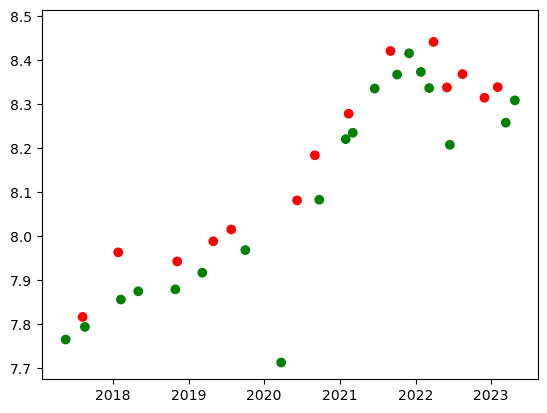

In [14]:
# Visualization of target variable (local minima and maxima)
local_max_indices = argrelextrema(data['Adj Close'].values, np.greater, order=15)[0]
local_min_indices = argrelextrema(data['Adj Close'].values, np.less, order=15)[0]
data['local_min_max'] = 0
data.loc[data.index.isin(data.index[local_max_indices]), 'local_min_max'] = -1
data.loc[data.index.isin(data.index[local_min_indices]), 'local_min_max'] = 1
colors = {-1:'r', 1: 'g', 0: '#00000000'}
plt.scatter(data.index, data['Adj Close'], c=data['local_min_max'].map(colors))
plt.show()

In [27]:
# All data
data = pd.concat([gdp, stock, unemployment], axis=1)
data['GDP_change'] = data['GDP_change'].fillna(method = 'ffill')
data['UNRATE_change'] = data['UNRATE_change'].fillna(method = 'ffill')

# Target 
local_max_indices = argrelextrema(data['Adj Close'].values, np.greater, order=1)[0]
local_min_indices = argrelextrema(data['Adj Close'].values, np.less, order=1)[0]
data['local_min_max'] = 0
data.loc[data.index.isin(data.index[local_max_indices]), 'local_min_max'] = -1
data.loc[data.index.isin(data.index[local_min_indices]), 'local_min_max'] = 1

# Features 
# data['SO'] = self.calc_stochastic_oscillator()
# data['DMI'] = self.calc_directional_movement_indicator()
# data['OBV'] = self.calc_obv()
data['deriv'] = data['Adj Close'].diff()
data['close_open'] = data['Open'] - data['Adj Close'].shift(1)
data['open_close'] = data['Adj Close'] - data['Open']
data['deriv_open'] = data['Open'].diff()
data['2nd_deriv'] = data['Adj Close'].diff().diff()
data['close_pos'] = data['Adj Close'] - (data['High'] + data['Low'])/2 
data['hi_deriv'] = data['High'].diff()
data['low_deriv'] = data['Low'].diff()
# data['5d_SMA'] = data.Close.rolling(window=5).mean()
# data['10d_SMA'] = data.Close.rolling(window=10).mean()
# data['25d_SMA'] = data.Close.rolling(window=25).mean()
# data['50d_SMA'] = data.Close.rolling(window=50).mean()
# data['100d_SMA'] = data.Close.rolling(window=100).mean()
# data['RSI'] = self.calculate_RSI()
data['12d_EMA'] = data.Close.ewm(span=12, adjust=False).mean()
data['26d_EMA'] = data.Close.ewm(span=26, adjust=False).mean()
data['macd'] = data['12d_EMA']- data['26d_EMA'] 
data['macdsignal'] = data.macd.ewm(span=9, adjust=False).mean()

data = data.dropna()
data

,GDP_change,Open,High,Low,Close,Adj Close,Volume,UNRATE_change,local_min_max,deriv,...,open_close,deriv_open,2nd_deriv,close_pos,hi_deriv,low_deriv,12d_EMA,26d_EMA,macd,macdsignal
1948-02-04,5.997,14.000000,14.000000,14.000000,14.000000,14.000000,0.000000e+00,0.4,1,-0.620000,...,0.000000,-0.620000,-0.530000,0.000000,-0.620000,-0.620000,14.538842,14.713345,-0.174503,-0.153913
1948-02-05,5.997,14.200000,14.200000,14.200000,14.200000,14.200000,0.000000e+00,0.4,-1,0.200000,...,0.000000,0.200000,0.820000,0.000000,0.200000,0.200000,14.486713,14.675319,-0.188607,-0.160852
1948-02-06,5.997,14.190000,14.190000,14.190000,14.190000,14.190000,0.000000e+00,0.4,1,-0.010000,...,0.000000,-0.010000,-0.210000,0.000000,-0.010000,-0.010000,14.441065,14.639370,-0.198305,-0.168342
1948-02-09,5.997,14.310000,14.310000,14.310000,14.310000,14.310000,0.000000e+00,0.4,-1,0.120001,...,0.000000,0.120001,0.130001,0.000000,0.120001,0.120001,14.420901,14.614972,-0.194071,-0.173488
1948-02-10,5.997,13.890000,13.890000,13.890000,13.890000,13.890000,0.000000e+00,0.4,0,-0.420000,...,0.000000,-0.420000,-0.540001,0.000000,-0.420000,-0.420000,14.339224,14.561270,-0.222047,-0.183200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,327.873,4132.069824,4142.410156,4117.770020,4137.040039,4137.040039,3.290940e+09,-0.1,-1,3.520020,...,4.970215,-0.070312,-0.209961,6.949951,4.390137,3.910156,4123.020306,4085.664275,37.356031,36.937361
2023-04-25,327.873,4126.430176,4126.430176,4071.379883,4071.629883,4071.629883,3.978640e+09,-0.1,0,-65.410156,...,-54.800293,-5.639648,-68.930176,-27.275146,-15.979980,-46.390137,4115.114087,4084.624690,30.489396,35.647768
2023-04-26,327.873,4087.780029,4089.669922,4049.350098,4055.989990,4055.989990,3.837030e+09,-0.1,1,-15.639893,...,-31.790039,-38.650146,49.770264,-13.520020,-36.760254,-22.029785,4106.018072,4082.503601,23.514470,33.221108
2023-04-27,327.873,4075.290039,4138.240234,4075.290039,4135.350098,4135.350098,3.750550e+09,-0.1,0,79.360107,...,60.060059,-12.489990,95.000000,28.584961,48.570312,25.939941,4110.530691,4086.418157,24.112534,31.399393


# Supervised Learning (Prediction)

In [ ]:
# Train test split
features = data.drop('local_min_max', axis=1).columns.to_list()
split = round(len(data)*0.2)
train = data.iloc[:-split]
test = data.iloc[-split:]
X_train = train[features]
y_train = train['local_min_max']
X_test = test[features]
y_test = test['local_min_max']

# Scale features 
scaler = StandardScaler() 
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

**Logistic Regression**

In [ ]:
# Hyperparameter tuning
model = LogisticRegression(max_iter = 10000, solver = 'liblinear', random_state = 0)
model.fit(X_train_scaled, y_train)
grid = {'C': [10**i for i in range(-5, 3)], 'penalty': ['l1', 'l2']}
clf = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy', verbose=1)
clf.fit(X_train_scaled, y_train)

# Test results
print("Best hyperparameters: ", clf.best_params_)
print("Best accuracy score: ", clf.best_score_)

final_model = clf.best_estimator_
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy", accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
coef_dict = {}
for coef, feat in zip(final_model.coef_[0,:],X_test.columns):
    coef_dict[feat] = coef
sorted_coef_dict = dict(sorted(coef_dict.items(), key=lambda x: abs(x[1]), reverse=True))
sorted_coef_dict

**OUTPUT SUGGESTS UNDERFITTING: C too low (too much regularization), test accuracy significantly lower, and all features except 1 got penalized completely --> increase model complexity**

Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best hyperparameters:  {'C': 0.001, 'penalty': 'l1'}

Best accuracy score:  0.5578644980750245

Test accuracy 0.5028712059064807

Coefficients: {'deriv': 0.1663103274570581,
 'GDP_change': 0.0,
 'Open': 0.0,
 'High': 0.0,
 'Low': 0.0,
 'Close': 0.0,
 'Adj Close': 0.0,
 'Volume': 0.0,
 'UNRATE_change': 0.0,
 'close_open': 0.0,
 'open_close': 0.0,
 'deriv_open': 0.0,
 '2nd_deriv': 0.0,
 'close_pos': 0.0,
 'hi_deriv': 0.0,
 'low_deriv': 0.0,
 '12d_EMA': 0.0,
 '26d_EMA': 0.0,
 'macd': 0.0,
 'macdsignal': 0.0}

**KNN (non-parametric, more complex, and computationally inexpensive for grid search)** 

Fitting 5 folds for each of 98 candidates, totalling 490 fits


/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no lo

Best hyperparameters:  {'n_neighbors': 48, 'weights': 'uniform'}
Best accuracy score:  0.4298997610576557
Test accuracy 0.49822258681979764


/Users/joepopop/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


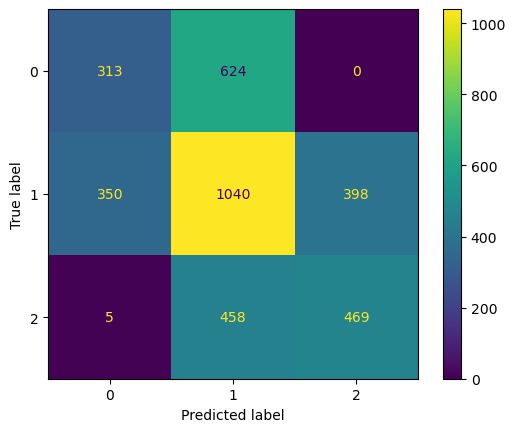

In [59]:
# Hyperparameter tuning
model = KNeighborsClassifier()
grid = {'n_neighbors': list(range(1, 50)), 'weights': ['uniform', 'distance']}
clf = GridSearchCV(estimator=model, param_grid=grid, cv=5, scoring='accuracy', verbose=1)
clf.fit(X_train_scaled, y_train)

# Test results
print("Best hyperparameters: ", clf.best_params_)
print("Best accuracy score: ", clf.best_score_)

final_model = clf.best_estimator_
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy", accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

# Backtesting

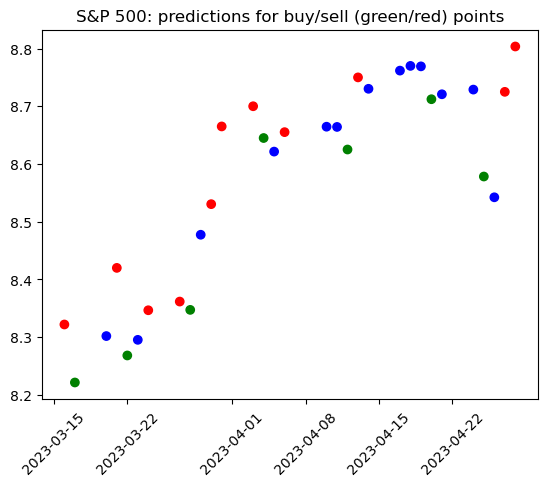

In [60]:
prob = np.max(final_model.predict_proba(X_test_scaled), axis=1)
y_pred = pd.DataFrame(data = y_pred, columns = ['Pred'], index = X_test.index.copy())
prob = pd.DataFrame(data = prob, columns = ['Prob'], index = X_test.index.copy())
X = pd.DataFrame(data = X_test_scaled, columns = features, index = X_test.index.copy())
temp = pd.merge(X, prob, how = 'left', left_index = True, right_index = True)
temp.sort_index()
df = pd.merge(temp, y_pred, how = 'left', left_index = True, right_index = True)
df.sort_index()

# Begin backtesting

first_buy_index = df.loc[df['Pred'] == 1].index[0]
df = df.loc[first_buy_index:]
# Create a new column to store the returns for each trade
df['trade_returns'] = np.nan
df['shares_bought'] = np.nan

# Initialize a variable to keep track of the shares bought for each trade
shares_bought = 0
money_spent = 0

# Iterate through the dataframe
for i, row in df.iterrows():
    if row['Pred'] == 1 and shares_bought == 0:
        # If the signal is 1 and have sold all previously owned shares, buy shares and add the amount to the shares_bought variable

        if row['Prob'] > 0.5:
          multiplier = 1
        else:
          multiplier = row['Prob']*2

        price = row['Adj Close']

        money_spent += 1 * multiplier
        shares_bought += money_spent / price


    # elif row['Pred'] == 1 and multiplier < 1 and row['Adj Close'] < price:
    #     money_spent += 1 * (1-multiplier)
    #     shares_bought += (1 * (1-multiplier)) / row['Adj Close']

    elif row['Pred'] == -1:
        # check if shares_bought is greater than zero before executing the trade_return calculation
        if shares_bought > 0:
            # If the signal is -1, calculate the returns for the trade by subtracting the bought price
            # from the sell price, and divide by the bought price
            trade_return = ((row['Adj Close'] * shares_bought) - (money_spent)) / 1
            # Assign the calculated return to the trade_returns column
            df.loc[i, 'trade_returns'] = trade_return
            # Reset the shares_bought variable
            shares_bought = 0
            money_spent = 0
    else:
        # If the signal is 0, do nothing
        pass
    df.loc[i, 'shares_bought'] = shares_bought

# Calculate the cumulative returns for all trades
df['cumulative_returns'] = (df['trade_returns'] + 1).cumprod()
cumulative_returns = df['cumulative_returns'].dropna().iat[-1]-1
days = len(data)
returns = (cumulative_returns+1)**(252/days)-1
volatility = df.trade_returns.std()*np.sqrt(252)  
colors = {-1:'r', 1: 'g', 0: 'b'
#                   '#00000000'
         }
plot_df = df[-31:]
plt.scatter(plot_df.index, plot_df['Adj Close'], c=plot_df['Pred'].map(colors))
plt.title('{}: predictions for buy/sell (green/red) points'.format('S&P 500'))
plt.xticks(rotation=45)
plt.show()

In [37]:
df

,GDP_change,Open,High,Low,Close,Adj Close,Volume,UNRATE_change,deriv,close_open,...,low_deriv,12d_EMA,26d_EMA,macd,macdsignal,Prob,Pred,trade_returns,shares_bought,cumulative_returns
2008-05-07,1.645040,2.429519,2.452194,2.430135,2.410545,2.410545,5.254217,1.885459,-4.341344,0.677606,...,-1.088536,2.421576,2.390772,2.596505,2.582363,0.442825,1,NaN,0.367407,NaN
2008-05-08,1.645040,2.378454,2.412868,2.426031,2.422309,2.422309,4.904772,1.885459,0.845125,0.732135,...,-0.337422,2.422289,2.393739,2.424503,2.584798,0.468717,0,NaN,0.367407,NaN
2008-05-09,1.645040,2.379796,2.395825,2.413787,2.400668,2.400668,4.470018,1.885459,-1.598249,0.633591,...,-0.969668,2.419560,2.394880,2.128770,2.523462,0.451829,0,NaN,0.367407,NaN
2008-05-12,1.645040,2.367690,2.416781,2.418634,2.435892,2.435892,4.261752,1.885459,2.560998,0.718994,...,0.357865,2.422676,2.398552,2.086631,2.465377,0.469879,0,NaN,0.367407,NaN
2008-05-13,1.645040,2.400707,2.421905,2.441961,2.434649,2.434649,5.173622,1.885459,-0.106287,0.712426,...,1.793491,2.425121,2.401860,2.021024,2.404869,0.464103,0,NaN,0.367407,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,4.453833,8.404617,8.681289,8.752684,8.728971,8.728971,4.149605,-0.483388,0.577369,0.662712,...,0.685730,8.707823,8.634550,6.474411,6.848779,0.467699,0,NaN,0.100323,NaN
2023-04-25,4.453833,8.392203,8.644732,8.645113,8.578381,8.578381,5.117400,-0.483388,-11.029846,0.462132,...,-8.374696,8.689600,8.632151,5.264561,6.605670,0.600202,1,NaN,0.100323,NaN
2023-04-26,4.453833,8.307130,8.560635,8.594030,8.542374,8.542374,4.918114,-0.483388,-2.648986,1.048126,...,-3.986746,8.668635,8.627256,4.035630,6.148206,0.440429,0,NaN,0.100323,NaN
2023-04-27,4.453833,8.279638,8.671750,8.654180,8.725080,8.725080,4.796411,-0.483388,13.348151,1.117103,...,4.653882,8.679036,8.636290,4.141005,5.804784,0.603359,-1,0.001284,0.000000,4.886347


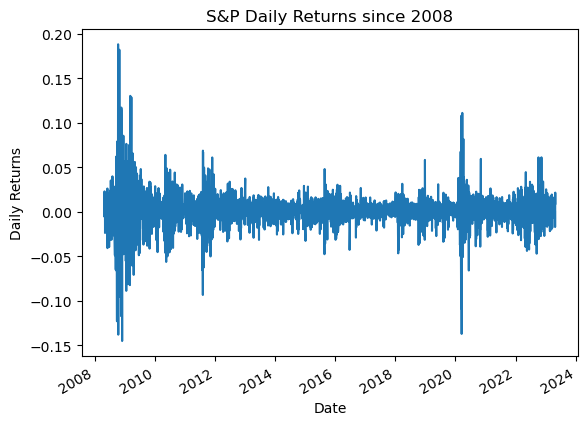

In [65]:
# S&P 500 hold 
df['daily_returns'] = df['Adj Close'].pct_change()
df['daily_returns'].plot()
plt.ylabel('Daily Returns')
plt.xlabel('Date')
plt.title('S&P Daily Returns since 2008')
plt.show()

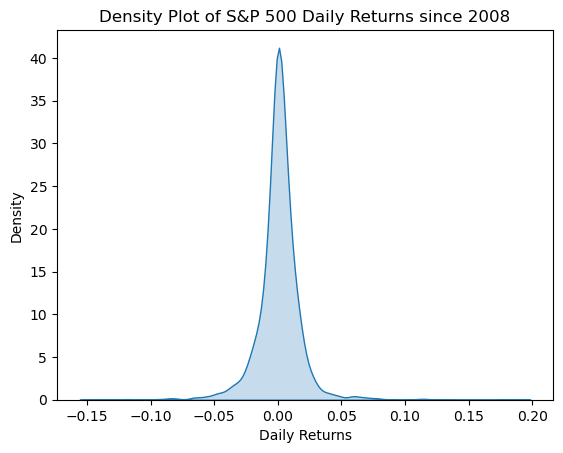

In [66]:
# S&P 500 hold
sns.kdeplot(df['daily_returns'], fill=True)
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.title('Density Plot of S&P 500 Daily Returns since 2008')
plt.show()

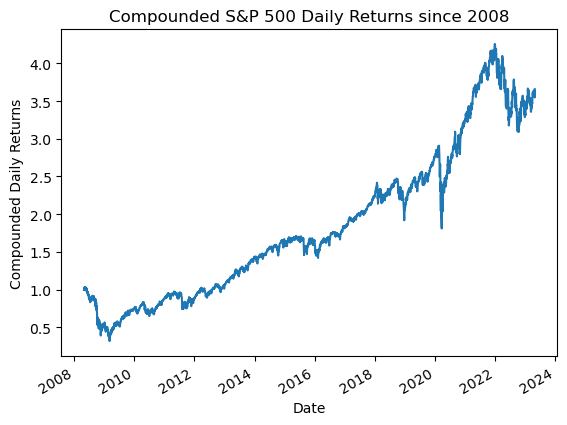

In [67]:
# S&P 500 hold
df['compounded_cum_return'] = (1 + df['daily_returns']).cumprod()
df['compounded_cum_return'].plot()
plt.ylabel('Compounded Daily Returns')
plt.xlabel('Date')
plt.title('Compounded S&P 500 Daily Returns since 2008')
plt.show()

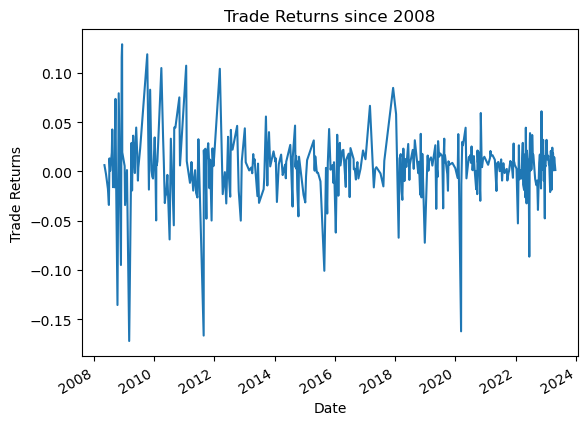

In [61]:
# trade strategy
df.loc[df['trade_returns'].notnull()]['trade_returns'].plot()
plt.ylabel('Trade Returns')
plt.xlabel('Date')
plt.title('Trade Returns since 2008')
plt.show()

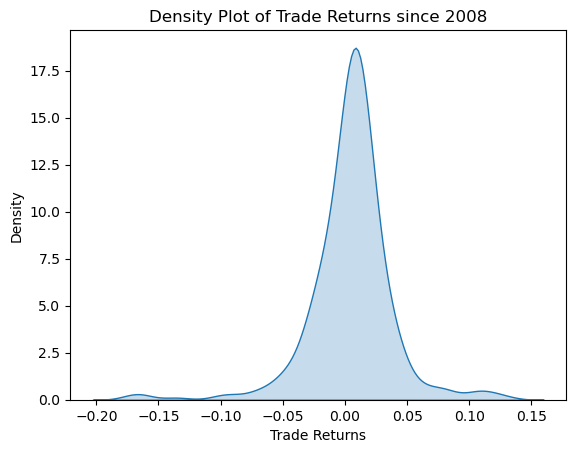

In [62]:
# trade strategy
sns.kdeplot(df['trade_returns'], fill=True)
plt.xlabel('Trade Returns')
plt.ylabel('Density')
plt.title('Density Plot of Trade Returns since 2008')
plt.show()

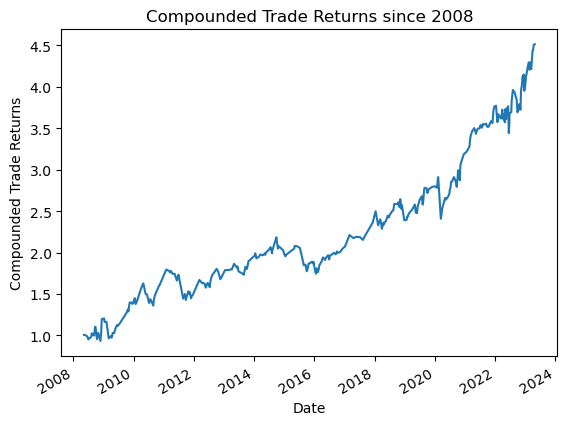

In [63]:
# trade strategy
df.loc[df['cumulative_returns'].notnull()]['cumulative_returns'].plot()
plt.ylabel('Compounded Trade Returns')
plt.xlabel('Date')
plt.title('Compounded Trade Returns since 2008')
plt.show()

In [68]:
df[['Adj Close', 'Pred', 'trade_returns', 'cumulative_returns', 'daily_returns', 'compounded_cum_return']].describe()

,Adj Close,Pred,trade_returns,cumulative_returns,daily_returns,compounded_cum_return
count,3653.000000,3653.000000,364.000000,364.000000,3652.000000,3652.000000
mean,4.466402,0.054476,0.004719,2.360460,0.000519,1.855983
std,2.425035,0.646026,0.033433,0.921528,0.018090,1.007618
min,0.762049,-1.000000,-0.171985,0.933097,-0.145320,0.316625
25%,2.297804,0.000000,-0.007163,1.714040,-0.005379,0.954659
50%,3.988545,0.000000,0.007199,2.076706,0.000823,1.657381
75%,5.892589,0.000000,0.017302,2.911018,0.007443,2.448448
max,10.239286,1.000000,0.129039,4.514609,0.188064,4.254330


In [69]:
# S&P 500 returns, volatility, and sharpe ratio
cumulative_returns = df['compounded_cum_return'].dropna().iat[-1]-1
years = len(df)/252
annualized_returns_sp = (cumulative_returns+1)**(1/years)-1

volatility_sp = df['daily_returns'].std()*np.sqrt(252)  

sharpe_ratio_sp = (annualized_returns_sp - 0.03)/volatility_sp

In [70]:
# trade strategy returns, volatility, and sharpe ratio
cumulative_returns = df['cumulative_returns'].dropna().iat[-1]-1
years = len(df)/252
annualized_returns_trd = (cumulative_returns+1)**(1/years)-1

num_trades = len(df.loc[df['trade_returns'].notnull()])
active_day_fraction = num_trades/len(df)
volatility_trd = df['trade_returns'].std()*np.sqrt(252*active_day_fraction)  

sharpe_ratio_trd = (annualized_returns_trd - 0.03)/volatility_trd

In [71]:
# Create two Pandas Series objects to store the data for each set
sp_data = pd.Series([annualized_returns_sp, volatility_sp, sharpe_ratio_sp], 
                      index=['Annualized Returns', 'Volatility', 'Sharpe Ratio'])
trd_data = pd.Series([annualized_returns_trd, volatility_trd, sharpe_ratio_trd], 
                      index=['Annualized Returns', 'Volatility', 'Sharpe Ratio'])

# Concatenate the two series into a single dataframe
comparison_table = pd.concat([sp_data, trd_data], axis=1)
comparison_table.columns = ['S&P 500 Hold', 'Trade Strategy']

# Print the table
display(comparison_table.T)

,Annualized Returns,Volatility,Sharpe Ratio
S&P 500 Hold,0.093588,0.287169,0.221430
Trade Strategy,0.109580,0.167532,0.475014
